# Introduction

In this research paper we will use the AID (Aerial image dataset), containing 30 different classes of aerial pictures, examples can be seen in the following visualization. We will use a selected DL algorithm to solve this as a scene classification task.

We are splitting the dataset into train, test and validation with a 80:10:10 split. Validation will be used for training evaluation, the test set will be used for final evaluation based on precission, recall, F1 score and accuracy.

For this research we are especially interested in different ways for normalizing the color bands and to find out what impact the most accurate normalization can have. 



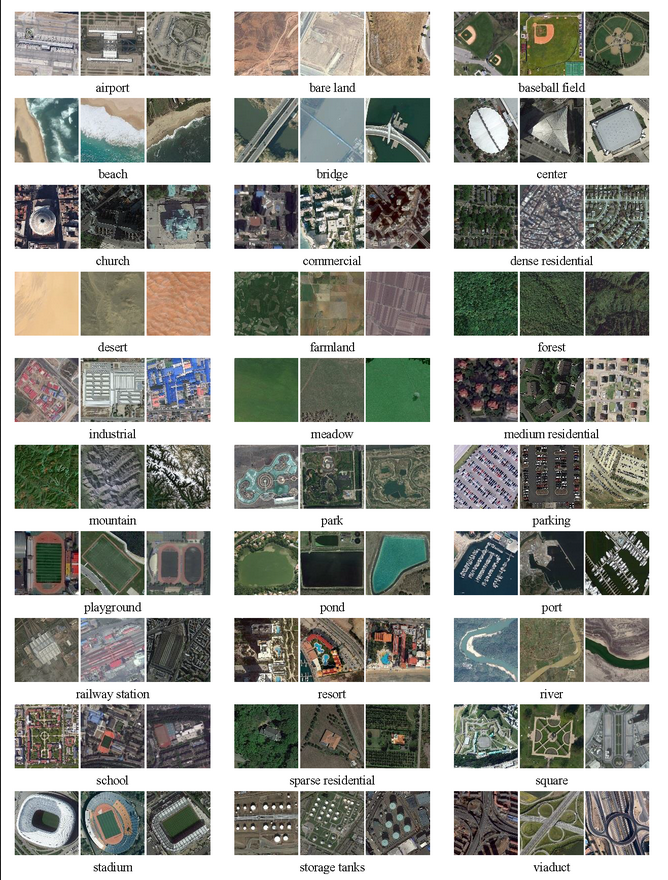

In [60]:
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import os
os.environ['kmp_duplicate_lib_ok'] ='true'
import numpy as np
import argparse
import random
import optuna
import time
from pathlib import Path
import time
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [61]:
# defining paths 

working_dir = r"c:/Users/Benedikt/Desktop/Mein_Ordner/WI-INFO/Semester_5/AI_Sensing/final_project"

#working_dir = Path.cwd()

dataset_path =  working_dir + "/archive/AID"
model_dir = working_dir + "/models"

train_txt_path = working_dir + "/train.txt"
val_txt_path =  working_dir + "/val.txt"
test_txt_path = working_dir + "/test.txt"
dataset_path

'c:/Users/Benedikt/Desktop/Mein_Ordner/WI-INFO/Semester_5/AI_Sensing/final_project/archive/AID'

# Data Preparation


In [62]:
# Data preparation

f_train = open(train_txt_path, 'w') #file names in the training set
f_val = open(val_txt_path, 'w') #file names in the training set
f_test = open(test_txt_path, 'w') #file names in the testing set


training_ratio = 0.8 #the percentage of train/test
val_ratio = 0.1

# write path and target category into 3 different txt files for train, test, val split 
# those text files will be used by the data loader for randomly loading images

for _, dirnames, _ in os.walk(dataset_path):
    dataDir = []
    for j in range(len(dirnames)):
        print('loading the dataset', dirnames[j], '...OK')
        dataDir = dataset_path + '/' + dirnames[j]
        for _, _, filenames in os.walk(dataDir):
            random.seed(123)
            random.shuffle(filenames)
            for i in range(len(filenames)): 
                if i<int(np.floor(len(filenames) * training_ratio)):
                    f_train.writelines(dataDir + '/' + str(filenames[i]) + ' ' + str(j) + '\n')
                elif i<int(np.floor(len(filenames) * (training_ratio + val_ratio))):
                    f_val.writelines(dataDir + '/' + str(filenames[i]) + ' ' + str(j) + '\n')
                else:
                    f_test.writelines(dataDir + '/' + str(filenames[i]) + ' ' + str(j) + '\n')

f_train.close()
f_test.close()
f_val.close()

loading the dataset Airport ...OK
loading the dataset BareLand ...OK
loading the dataset BaseballField ...OK
loading the dataset Beach ...OK
loading the dataset Bridge ...OK
loading the dataset Center ...OK
loading the dataset Church ...OK
loading the dataset Commercial ...OK
loading the dataset DenseResidential ...OK
loading the dataset Desert ...OK
loading the dataset Farmland ...OK
loading the dataset Forest ...OK
loading the dataset Industrial ...OK
loading the dataset Meadow ...OK
loading the dataset MediumResidential ...OK
loading the dataset Mountain ...OK
loading the dataset Park ...OK
loading the dataset Parking ...OK
loading the dataset Playground ...OK
loading the dataset Pond ...OK
loading the dataset Port ...OK
loading the dataset RailwayStation ...OK
loading the dataset Resort ...OK
loading the dataset River ...OK
loading the dataset School ...OK
loading the dataset SparseResidential ...OK
loading the dataset Square ...OK
loading the dataset Stadium ...OK
loading the data

In [63]:
# most accurate mean and std_dev calculation, thus a z-score transformation

pathfile = r"C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_5\AI_Sensing\final_project\train.txt"
root_dir = ""

pf = open(pathfile, 'r')
imgs = []
for line in pf:
    line = line.rstrip('\n')
    words = line.split()
    name = words[0].split('/')[-1].split('.')[0]
    imgs.append((root_dir+words[0],int(words[1]),name))           
pf.close()

counter = 0
initial = 0

for element in imgs:
    img = Image.open(element[0])
# Define transform to convert the image to PyTorch Tensor
    transform = transforms.ToTensor()

# Convert image to PyTorch Tensor (Image Tensor)
    imgTensor =  transform(img)
    imgTensor = imgTensor.unsqueeze(0)

    if initial == 0:
        initial = 1
        all_image_tensor = imgTensor
    else:
        all_image_tensor = torch.cat((all_image_tensor, imgTensor), 0)
    counter+=1
    if counter == 5:
        break
# Compute mean of the Image Tensor across image channels RGB
    #R_mean, G_mean ,B_mean = torch.mean(all_image_tensor, dim = (2,3))
all_mean = torch.mean(all_image_tensor, dim = (0,2,3))
all_std = torch.std(all_image_tensor, dim = (0,2,3))

print("Mean values for RGB: ",all_mean, "\n\nStd_dev values for RGB: ",all_std)

Mean values for RGB:  tensor([0.5502, 0.5468, 0.5135]) 

Std_dev values for RGB:  tensor([0.1665, 0.1651, 0.1737])


In [64]:
# initial implementation for mean/std_dev calculation, which yields sub-optimal predictive performance

#pathfile = r"C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_5\AI_Sensing\final_project\train.txt"
#root_dir = ""

#pf = open(pathfile, 'r')
#imgs = []
#for line in pf:
#    line = line.rstrip('\n')
#    words = line.split()
#    name = words[0].split('/')[-1].split('.')[0]
#    imgs.append((root_dir+words[0],int(words[1]),name))           
#pf.close()


#red_mean_list = []
#green_mean_list = []
#blue_mean_list = []

#red_std_list = []
#green_std_list = []
#blue_std_list = []

#counter = 0

#for element in imgs:
#    img = Image.open(element[0])
# Define transform to convert the image to PyTorch Tensor
#    transform = transforms.ToTensor()

# Convert image to PyTorch Tensor (Image Tensor)
#    imgTensor =  transform(img)
    
# Compute mean of the Image Tensor across image channels RGB
#    R_mean, G_mean ,B_mean = torch.mean(imgTensor, dim = [1,2])
#    R_std, G_std ,B_std = torch.std(imgTensor, dim = [1,2])

#    red_mean_list.append(R_mean.item())
#    green_mean_list.append(G_mean.item())
#    blue_mean_list.append(B_mean.item())

#    red_std_list.append(R_std.item())
#    green_std_list.append(G_std.item())
#    blue_std_list.append(B_std.item())


#red_final_mean =  sum(red_mean_list) / len(red_mean_list)
#green_final_mean = sum(green_mean_list) / len(green_mean_list)
#blue_final_mean = sum(blue_mean_list) / len(blue_mean_list)

# we are taking the mean of all image specific std deviations, not perfect but should be close enough
#red_final_std =  sum(red_std_list) / len(red_std_list)
#green_final_std = sum(green_std_list) / len(green_std_list)
#blue_final_std = sum(blue_std_list) / len(blue_std_list)

#print("Mean values: \nRed: ", red_final_mean, "Green: ", green_final_mean, "Blue: " ,blue_final_mean, "\n\nStd deviation values: \nRed: ", red_final_std, "Green: ", green_final_std, "Blue: ", blue_final_std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


playground_316
torch.Size([3, 256, 256])
tensor(18)


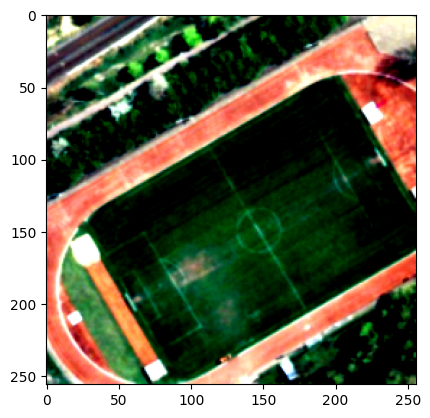

In [65]:
# Data loader

num_classes = 30
class_name_list = ["Airport", "BareLand", "BaseballField", "Beach", "Bridge", "Center", "Church",
    "Commercial", "DenseResidential", "Desert", "Farmland", "Forest", "Industrial", "Meadow", "MediumResidential",
    "Mountain", "Park", "Parking", "Playground", "Pond", "Port", "RailwayStation", "Resort", "River", "School",
    "SparseResidential", "Square", "Stadium", "StorageTanks", "Viaduct"]

def default_loader(path):
    return Image.open(path).convert('RGB')
 
class UCM_dataset(Dataset):
    def __init__(self, root_dir, pathfile, transform=None, loader=default_loader):
        pf = open(pathfile, 'r')
        imgs = []
        for line in pf:
            line = line.rstrip('\n')
            words = line.split()
            name = words[0].split('/')[-1].split('.')[0]
            imgs.append((root_dir+words[0],int(words[1]),name))           

        self.imgs = imgs
        self.transform = transform
        self.loader = loader
        pf.close()
 
    def __getitem__(self, index):        
        fn, class_name, name = self.imgs[index]
        img = self.loader(fn)        
        if self.transform is not None:            
            img = self.transform(img)       
        return img,class_name,name
 
    def __len__(self):
        return len(self.imgs)
    


composed_transforms_train = transforms.Compose([
        transforms.Resize(size=(256, 256)),    
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0)),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        #transforms.Normalize(mean=(0.397, 0.409, 0.406), std=(0.158,  0.145, 0.140))]) #1. calculation
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])   # generic values
        #transforms.Normalize(mean=(all_mean[0], all_mean[1], all_mean[2]), std=(all_std[0], all_std[1], all_std[2]))])   # values from more exact calculation

    
composed_transforms_test = transforms.Compose([
        transforms.Resize(size=(256, 256)),    
        transforms.ToTensor(),
        #transforms.Normalize(mean=(0.397, 0.409, 0.406), std=(0.158,  0.145, 0.140))]) #1. calculation
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])   # generic values 
        #transforms.Normalize(mean=(all_mean[0], all_mean[1], all_mean[2]), std=(all_std[0], all_std[1], all_std[2]))])   # values from more exact calculation

batch_size_train = 32
batch_size_test = 1

num_workers = 0


train_loader = torch.utils.data.DataLoader(UCM_dataset(root_dir = '', 
    pathfile= train_txt_path, transform=composed_transforms_train), 
    batch_size=batch_size_train, shuffle=True, num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(UCM_dataset(root_dir = '', 
    pathfile= val_txt_path, transform=composed_transforms_test), 
    batch_size=batch_size_test, shuffle=False, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(UCM_dataset(root_dir = '', 
    pathfile= test_txt_path, transform=composed_transforms_test), 
    batch_size=batch_size_test, shuffle=False, num_workers=num_workers)

for batch_index, src_data in enumerate(train_loader):
    img, gt, name = src_data
    print(name[0])
    print(img[0].shape)
    print(gt[0])
    plt.imshow(np.moveaxis(img[0].numpy().squeeze(),0,-1))
    break


# Model initialization and training loop definition

In [66]:
# Network initializaztion
import torchvision.models as models
from torch import nn

#network = 'resnet18'
network = 'resnet34'
lr = 0.0005

if network=='alexnet':
    Model = models.alexnet(pretrained=True)
    Model.classifier._modules['6'] = nn.Linear(4096, num_classes) 
elif network=='vgg16':
    Model = models.vgg16(pretrained=True)  
    Model.classifier._modules['6'] = nn.Linear(4096, num_classes)
elif network=='resnet18':
    Model = models.resnet18(pretrained=True)  
    Model.fc = torch.nn.Linear(Model.fc.in_features, num_classes)
elif network=='resnet34':
    Model = models.resnet34(pretrained=True)  
    Model.fc = torch.nn.Linear(Model.fc.in_features, num_classes)

# device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU!")
else:
    device = torch.device("cpu")
    print("Using CPU!")
    
Model = Model.to(device)
Model_optimizer = torch.optim.Adam(Model.parameters(),lr=lr)


lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Model_optimizer, mode='max', factor=0.1, patience=2, threshold=0.0001,)

Using CPU!


In [67]:
def evaluate_on_validation(Model):
    # evaluation function using the validation set to run after every epochs
    Model.eval()
    num_batches = len(val_loader)

    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    preds = []
    target = []
    total = 0
    correct = 0
    class_acc = np.zeros((num_classes,1))
    with torch.no_grad():
        for id, data in enumerate(val_loader):
            img, gt, _ = data
            img = img.to(device)
            gt = gt.to(device)
            
            output = Model(img)
            _, predicted = torch.max(output, 1)
            preds.append(predicted.item())
            target.append(gt.item())
            c = (predicted == gt).squeeze()
            total += batch_size_test
            correct += (predicted == gt).sum().item()
            class_correct[gt] += c.item()
            class_total[gt] += 1
        acc = 1.0*correct / total
        print('Epoch[%d]Validation-Accuracy: %.2f %%' % (epoch,100.0 * acc))
    return acc


In the following we are defining our training loop. First defining the number of epochs to execute, loss function, optimizers and when to apply learning rate decay. 

In [79]:
# Training model

# n_epochs = 20
# n_epochs = 25

print_per_batches = 200
num_batches = len(train_loader)
ce_loss = torch.nn.CrossEntropyLoss()
num_steps = n_epochs * num_batches
hist = np.zeros((num_steps,3))
index_i = -1

for epoch in range(n_epochs):
    for batch_index, src_data in enumerate(train_loader):
        index_i += 1

        tem_time = time.time()
        Model.train()
        Model_optimizer.zero_grad()

        img_train, gt_train, _ = src_data
        img_train = img_train.to(device)
        gt_train = gt_train.to(device)
        
        output = Model(img_train)

        # CE Loss            
        _, pred_label = torch.max(output, 1)            
        loss = ce_loss(output, gt_train)
        loss.backward()

        Model_optimizer.step()            
        
        hist[index_i,0] = time.time()-tem_time
        hist[index_i,1] = loss.item()   
        hist[index_i,2] = torch.mean((pred_label == gt_train).float()).item() 

        tem_time = time.time()
        if (batch_index+1) % print_per_batches == 0:
            print('Epoch %d/%d:  %d/%d Time cost per iter: %.2f ce_loss = %.3f acc = %.3f \n'\
            %(epoch+1, n_epochs,batch_index+1,num_batches,
            np.mean(hist[index_i-print_per_batches+1:index_i+1,0]),
            np.mean(hist[index_i-print_per_batches+1:index_i+1,1]),
            np.mean(hist[index_i-print_per_batches+1:index_i+1,2])))
    
    
    acc = evaluate_on_validation(Model)
    
    Model.train()
    lr_scheduler.step(acc)

Epoch 1/5:  200/250 Time cost per iter: 6.77 ce_loss = 0.254 acc = 0.920 

Epoch[0]Validation-Accuracy: 88.50 %
Epoch 2/5:  200/250 Time cost per iter: 6.36 ce_loss = 0.208 acc = 0.933 

Epoch[1]Validation-Accuracy: 87.70 %
Epoch 3/5:  200/250 Time cost per iter: 6.04 ce_loss = 0.190 acc = 0.941 

Epoch[2]Validation-Accuracy: 90.50 %
Epoch 4/5:  200/250 Time cost per iter: 6.03 ce_loss = 0.168 acc = 0.944 

Epoch[3]Validation-Accuracy: 89.30 %
Epoch 5/5:  200/250 Time cost per iter: 5.81 ce_loss = 0.179 acc = 0.940 

Epoch[4]Validation-Accuracy: 90.00 %


In [77]:
# saving model
model_path = model_dir + "/resnet_34_256x256_lr0.0005_20epochs_generic_normalization.pt"
# model_path = model_dir + "/resnet_34_256x256_lr0.0005_20epochs_specific_normalization.pt"
# model_path = model_dir + "/resnet_18_256x256_lr0.0005_20epochs_generic_normalization.pt"
# model_path = model_dir + "/resnet_18_256x256_lr0.0005_20epochs_specific_normalization.pt"

 torch.save(Model, model_path)


# Evaluation of all trained models

In [78]:
# loading model
Model = torch.load(model_path)
Model.eval()

# device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU!")
else:
    device = torch.device("cpu")
    print("Using CPU!")
    
Model = Model.to(device)
Model_optimizer = torch.optim.Adam(Model.parameters(),lr=lr)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Model_optimizer, mode='max', factor=0.1, patience=2, threshold=0.0001)

Using CPU!


In [71]:
# Testing model
Model.eval()
num_batches = len(test_loader)

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
preds = []
target = []
total = 0
correct = 0
class_acc = np.zeros((num_classes,1))
with torch.no_grad():
    for id, data in enumerate(test_loader):
        img, gt, _ = data
        img = img.to(device)
        gt = gt.to(device)
        
        output = Model(img)
        _, predicted = torch.max(output, 1)
        preds.append(predicted.item())
        target.append(gt.item())
        c = (predicted == gt).squeeze()
        total += batch_size_test
        correct += (predicted == gt).sum().item()
        class_correct[gt] += c.item()
        class_total[gt] += 1
    for i in range(num_classes):
        class_acc[i] = 1.0*class_correct[i] / class_total[i]
        print('---------------Accuracy of %12s : %.2f %%---------------' % (
            class_name_list[i], 100 * class_acc[i])) 
    acc = 1.0*correct / total
    print('---------------Epoch[%d]Validation-OA: %.2f %%---------------' % (epoch,100.0 * acc))
    print('---------------Epoch[%d]Validation-AA: %.2f %%---------------' % (epoch,100.0 * np.mean(class_acc)))

---------------Accuracy of      Airport : 100.00 %---------------
---------------Accuracy of     BareLand : 96.77 %---------------
---------------Accuracy of BaseballField : 100.00 %---------------
---------------Accuracy of        Beach : 100.00 %---------------
---------------Accuracy of       Bridge : 97.22 %---------------
---------------Accuracy of       Center : 84.62 %---------------
---------------Accuracy of       Church : 100.00 %---------------
---------------Accuracy of   Commercial : 100.00 %---------------
---------------Accuracy of DenseResidential : 100.00 %---------------
---------------Accuracy of       Desert : 93.33 %---------------
---------------Accuracy of     Farmland : 97.30 %---------------
---------------Accuracy of       Forest : 100.00 %---------------
---------------Accuracy of   Industrial : 92.31 %---------------
---------------Accuracy of       Meadow : 100.00 %---------------
---------------Accuracy of MediumResidential : 100.00 %---------------
------

In [72]:
# calculating metrics
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassF1Score, MulticlassPrecision, MulticlassRecall, MulticlassAccuracy

num_classes = 30

preds_tensor = torch.tensor(preds)
target_tensor = torch.tensor(target)


# confusion matrix
confmat = MulticlassConfusionMatrix(task="multiclass", num_classes=num_classes)
conf_matrix = confmat(preds_tensor, target_tensor)

# f1 score
f1 = MulticlassF1Score(num_classes=num_classes, average=None)
f1_values = f1(preds_tensor, target_tensor)

# accuracy
multi_class_accu = MulticlassAccuracy(num_classes=num_classes, average=None)
accuracy = multi_class_accu(preds_tensor, target_tensor)

# precission
multi_precission = MulticlassPrecision(num_classes=num_classes, average=None)
precission = multi_precission(preds_tensor, target_tensor)

# recall
multi_recall = MulticlassRecall(num_classes=num_classes, average=None)
recall = multi_recall(preds_tensor, target_tensor)

In [73]:
# we merge all prediction metrics to a pandas df for easy visualization

# Convert tensors to NumPy arrays
array1 = f1_values.numpy()
array2 = accuracy.numpy()
array3 = precission.numpy()
array4 = recall.numpy()
array5 = class_name_list

# Create a dictionary with column names and NumPy arrays
data = {
    'F1_values': array1,
    'Accuracy': array2,
    'Precission': array3,
    'Recall' : array4,
    'Class_name' : array5
}

# Create a Pandas DataFrame
metrics = pd.DataFrame(data)
metrics.set_index('Class_name', inplace=True)
metrics.to_csv("output/metrics_resnet34_256x256_epoch_20_.csv", index = True)


mean_data = {
    'F1_value_mean': array1.mean(),
    'Accuracy_mean': array2.mean(),
    'Precission_mean': array3.mean(),
    'Recall_mean' : array4.mean(),
    }

mean_data

{'F1_value_mean': 0.93864983,
 'Accuracy_mean': 0.9397449,
 'Precission_mean': 0.9426485,
 'Recall_mean': 0.9397449}

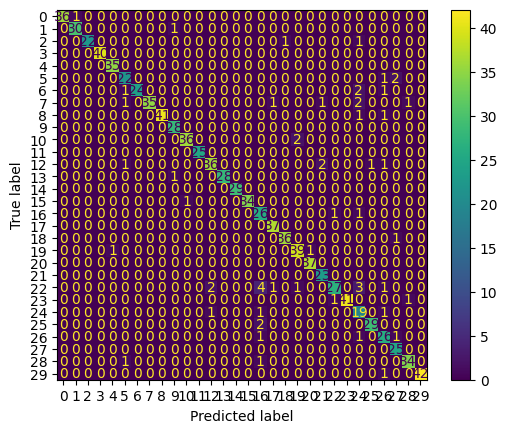

In [74]:
# for visualizing confusion matrix
cm = confusion_matrix(preds_tensor, target_tensor)
ConfusionMatrixDisplay(cm).plot()